# Customer Segmentation for Online Retail

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler,  OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [3]:
# Get the current working directory
current_directory = os.getcwd()
# Correctly join the path to the data file, relative to the script's location
file_path = os.path.join(current_directory, "../data", "customers.csv")

In [4]:
# Correctly join the path to the data file, relative to the script's location
file_path_df = os.path.join(current_directory, "../data", "customersFiltered.csv")

### Variables

- **Description:** This column contains the name of the product being purchased. For example, "WHITE HANGING HEART T-LIGHT HOLDER".
- **Quantity:** The number of items being purchased in a single transaction. For example, 6 units of "WHITE HANGING HEART T-LIGHT HOLDER".
- **InvoiceDate:** The date and time of the transaction. The format is "MM/DD/YYYY HH:MM".
- **UnitPrice:** The price per unit of the product. For instance, the "WHITE HANGING HEART T-LIGHT HOLDER" costs 2.55 currency units each.
- **CustomerID:** A unique identifier for the customer making the purchase. For example, the customer ID 17850.
- **Country:** The country where the customer is located.

## Phase 1: Data Exploration

Begin by thoroughly exploring the dataset to understand its structure, the types of data it contains, and any initial patterns. This includes examining summary statistics, visualizing distributions, and identifying any anomalies or missing values.

In [ ]:
# Define column names and types
column_names = ["Description", "Quantity", "InvoiceDate", "UnitPrice", "CustomerID", "Country", "target"]
column_types = {
    "Description": "string",
    "Quantity": "float",
    "InvoiceDate": "string",  # Temporary read as string to parse date format later
    "UnitPrice": "float",
    "CustomerID": "string",
    "Country": "string",
    "target": "string"
}

# Read the CSV file
df = pd.read_csv(file_path, names=column_names, dtype=column_types, skiprows=1)


**The new name for "target" is "profile"**

In [ ]:
df.rename(columns={"target": "profile"}, inplace=True)

## Phase 2: Data Preprocessing
Prepare the data for analysis by cleaning it. This involves handling missing values, removing duplicates. Ensure the data is in a suitable format for the next steps.

### 2.1. Handling Missing Values 

In [ ]:
#####################################################
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Amount"]=df["Quantity"]*df["UnitPrice"]
Income=df["Amount"].sum()
print('Income is ', Income)
NumberOfClients=df['CustomerID'].nunique()
print('Number of clients ',NumberOfClients)
df=df.drop(["Quantity","UnitPrice","profile"], axis=1)
df['CustomerID'] = df['CustomerID'].fillna('99999')
#####################################################
NumberOfClients=df['CustomerID'].nunique()
print('Number of clients ',NumberOfClients)
#####################################################

### 2.2. Handling Negative Purchase

In [ ]:
# Group by 'CustomerID' and 'InvoiceDate' and sum the 'Amount'
df_bag = df.groupby(['CustomerID','InvoiceDate'], as_index=False)['Amount'].sum()
# Rename the 'Amount' column to 'BagAmount'
df_bag.rename(columns={'Amount': 'BagAmount'}, inplace=True)
df_Custom = df_bag.groupby(['CustomerID'], as_index=False)['BagAmount'].sum()
df_Custom.rename(columns={'BagAmount': 'CustomerValue'}, inplace=True)
df_Custom.head()
######################################################################################
negative_customers = df_Custom[df_Custom['CustomerValue'] <= 0]['CustomerID'].tolist()
len(negative_customers)
######################################################################################
df_filtered = df[~df['CustomerID'].isin(negative_customers)]

# Correctly join the path to the data file, relative to the script's location
file_path_df = os.path.join(current_directory, "../data", "customersFiltered.csv")
df_filtered.to_csv(file_path_df, index=False)
####################################################################################

### Working with time and not only

In [ ]:
# Correctly join the path to the data file, relative to the script's location
df_filtered.to_csv(file_path_df, index=False)


In [ ]:
import gc

del df
df_bag
del df_Custom
del df_filtered

gc.collect()
print("Memory cleared!")

### New round of cleaning

In [5]:
# Read the CSV file

df = pd.read_csv(file_path_df)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df.head()

,Description,InvoiceDate,CustomerID,Country,Amount
0,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 08:26:00,17850.0,United Kingdom,15.30
1,WHITE METAL LANTERN,2010-12-01 08:26:00,17850.0,United Kingdom,20.34
2,CREAM CUPID HEARTS COAT HANGER,2010-12-01 08:26:00,17850.0,United Kingdom,22.00
3,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,17850.0,United Kingdom,20.34
4,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,17850.0,United Kingdom,20.34


In [6]:
# Group by 'CustomerID' and 'InvoiceDate' and sum the 'Amount'
df_bag = df.groupby(['CustomerID','InvoiceDate'], as_index=False)['Amount'].sum()
df_bag.rename(columns={'Amount': 'BagAmount'}, inplace=True)
df_bag = df_bag[df_bag['CustomerID'] != 99999]
df_bag.shape

(21948, 3)

### 2.2. Removing duplicates

In [7]:
# Count the number of duplicate rows 
duplicate_count = df_bag.duplicated().sum() 
# Print the number of duplicate rows 
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


### 2.3. Data Formats

In [ ]:
df_bag.columns

In [ ]:
df_bag['BagAmount'].sum()

In [ ]:
df_bag.dtypes

In [ ]:
df_bag.shape

## Phase 3: Feature Engineering
Create the key variables needed for customer segmentation:

- **Frequency: The number of times a customer has made a purchase.**
- **Recency: The number of days since the customer's last purchase.**
- **Monetary: The total amount of money spent by the customer.**

### 3.1. Additional variables

**One can use any additional variable which could be interpreted as KPI**

### 3.2. FRM-analysis

In [8]:
# Compute RFM (Recency, Frequency, Monetary) values for each customer
# Use the last date in the dataframe as the current date

current_date = df_bag["InvoiceDate"].max()

df_bag["LastOrder"]=(current_date-df_bag["InvoiceDate"]).dt.days
last_order_mean=df_bag.groupby("CustomerID")["LastOrder"].min().reset_index()
last_order_mean.columns=["CustomerID","Recency"]
last_order_mean['RecencyScore'] = np.log1p(last_order_mean['Recency'])

first_order_mean=df_bag.groupby("CustomerID")["LastOrder"].max().reset_index()
first_order_mean.columns=["CustomerID","Tenure"]
first_order_mean['TenureScore'] = np.log1p(first_order_mean['Tenure'])

last_order_mean=last_order_mean.merge(first_order_mean, on="CustomerID")
last_order_mean.head()

,CustomerID,Recency,RecencyScore,Tenure,TenureScore
0,12347.0,1,0.693147,366,5.905362
1,12348.0,74,4.317488,357,5.880533
2,12349.0,18,2.944439,18,2.944439
3,12350.0,309,5.736572,309,5.736572
4,12352.0,35,3.583519,296,5.693732


In [9]:
# Calculate the sum of amounts for each customer
amount_sums = df_bag.groupby("CustomerID")["BagAmount"].sum().reset_index()
amount_sums.columns = ["CustomerID", "Monetary"]
amount_sums['MonetaryScore'] = np.log1p(amount_sums['Monetary'])
last_order_mean=last_order_mean.merge(amount_sums, on="CustomerID")
last_order_mean.head()


,CustomerID,Recency,RecencyScore,Tenure,TenureScore,Monetary,MonetaryScore
0,12347.0,1,0.693147,366,5.905362,4310.00,8.368925
1,12348.0,74,4.317488,357,5.880533,1797.24,7.494564
2,12349.0,18,2.944439,18,2.944439,1757.55,7.472245
3,12350.0,309,5.736572,309,5.736572,334.40,5.815324
4,12352.0,35,3.583519,296,5.693732,1545.41,7.343691


In [10]:
# Calculate the 1st and 99th percentiles
lower_bound = amount_sums['MonetaryScore'].quantile(0.01)
upper_bound = amount_sums['MonetaryScore'].quantile(0.99)

print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")

# Remove outliers based on the calculated bounds
RFM_no_outliers = amount_sums[(amount_sums['MonetaryScore'] >= lower_bound) & (amount_sums['MonetaryScore'] <= upper_bound)]

# Display the number of rows before and after removing outliers
print(f"Original DataFrame shape: {amount_sums.shape}")
print(f"DataFrame shape after removing outliers: {RFM_no_outliers.shape}")

RFM_no_outliers.head()

Lower Bound: 3.976177452868147
Upper Bound: 9.76974951711644
Original DataFrame shape: (4319, 3)
DataFrame shape after removing outliers: (4231, 3)


,CustomerID,Monetary,MonetaryScore
0,12347.0,4310.00,8.368925
1,12348.0,1797.24,7.494564
2,12349.0,1757.55,7.472245
3,12350.0,334.40,5.815324
4,12352.0,1545.41,7.343691


In [11]:
order_counts = df_bag.groupby("CustomerID")["InvoiceDate"].nunique().reset_index() 
order_counts.columns = ["CustomerID", "Frequency"]
order_counts['FrequencyScore'] = np.log1p(order_counts['Frequency'])
last_order_mean=last_order_mean.merge(order_counts, on="CustomerID")
last_order_mean.head()

,CustomerID,Recency,RecencyScore,Tenure,TenureScore,Monetary,MonetaryScore,Frequency,FrequencyScore
0,12347.0,1,0.693147,366,5.905362,4310.00,8.368925,7,2.079442
1,12348.0,74,4.317488,357,5.880533,1797.24,7.494564,4,1.609438
2,12349.0,18,2.944439,18,2.944439,1757.55,7.472245,1,0.693147
3,12350.0,309,5.736572,309,5.736572,334.40,5.815324,1,0.693147
4,12352.0,35,3.583519,296,5.693732,1545.41,7.343691,11,2.484907


In [12]:
# Merge order counts and amount sums with the original dataframe 
# Merge dataframes to create the clients dataframe 
RFM=last_order_mean.copy()
RFM.head()

,CustomerID,Recency,RecencyScore,Tenure,TenureScore,Monetary,MonetaryScore,Frequency,FrequencyScore
0,12347.0,1,0.693147,366,5.905362,4310.00,8.368925,7,2.079442
1,12348.0,74,4.317488,357,5.880533,1797.24,7.494564,4,1.609438
2,12349.0,18,2.944439,18,2.944439,1757.55,7.472245,1,0.693147
3,12350.0,309,5.736572,309,5.736572,334.40,5.815324,1,0.693147
4,12352.0,35,3.583519,296,5.693732,1545.41,7.343691,11,2.484907


In [13]:
######################## New Features #########################################################################
#Customer Lifetime Value (CLV)
RFM['CLV'] = RFM['Monetary'] * RFM['Frequency']
#RFM Score
RFM['RFMScore'] = RFM['Recency'] * RFM['Frequency'] * RFM['Monetary']
#Spend Frequency Ratio
RFM['SpendFrequencyRatio'] = RFM['Frequency'] / (RFM['Recency'] + 1)
# High-Value Customers Indicator
threshold_monetary = RFM['Monetary'].quantile(0.75)
threshold_frequency = RFM['Frequency'].quantile(0.75)
RFM['HighValueCustomer'] = (RFM['Monetary'] > threshold_monetary) & (RFM['Frequency'] > threshold_frequency)
################################################################################################################

RFM.columns
#RFM.shape

Index(['CustomerID', 'Recency', 'RecencyScore', 'Tenure', 'TenureScore',
       'Monetary', 'MonetaryScore', 'Frequency', 'FrequencyScore', 'CLV',
       'RFMScore', 'SpendFrequencyRatio', 'HighValueCustomer'],
      dtype='object')

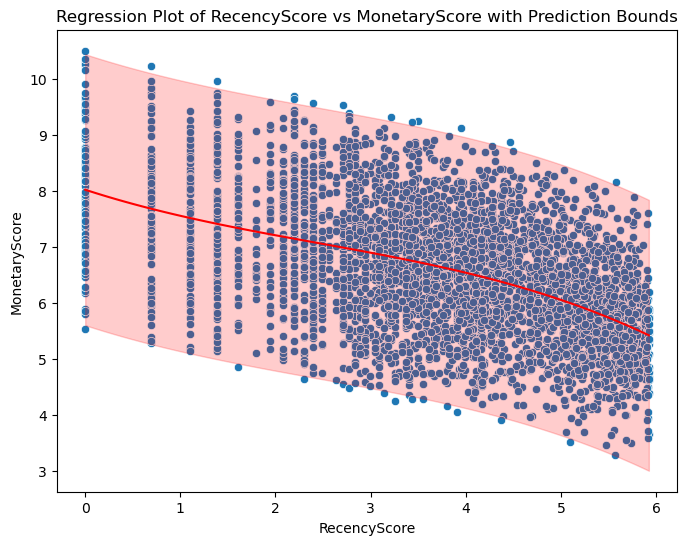

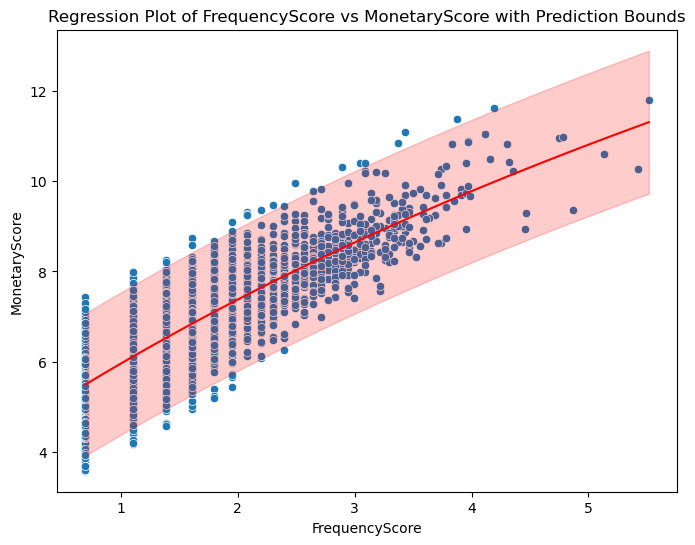

In [14]:
# Function to fit a regression model and get prediction bounds
def get_prediction_bounds(x, y, percentile=0.99):
    model = np.poly1d(np.polyfit(x, y, 3))
    x_minmax = np.linspace(x.min(), x.max(), 100)
    y_pred = model(x_minmax)
    se = np.sqrt((np.sum((y - model(x))**2)) / (len(y) - 2))
    t_value = np.abs(np.percentile(np.random.standard_t(df=len(x)-2, size=1000), 100 * (1 - (1 - percentile) / 2)))
    bound = t_value * se * np.sqrt(1 + 1/len(y) + (x_minmax - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    
    return model, x_minmax, y_pred, bound

# Function to remove outliers based on prediction bounds
def remove_outliers_based_on_bounds(ddf, x_col, y_col):
    x = ddf[x_col]
    y = ddf[y_col]
    model, x_minmax, y_pred, bound = get_prediction_bounds(x, y)
    predictions = model(x)
    se = np.sqrt((np.sum((y - model(x))**2)) / (len(y) - 2))
    t_value = np.abs(np.percentile(np.random.standard_t(df=len(x)-2, size=1000), 100 * (1 - (1 - 0.99) / 2)))
    bound = t_value * se * np.sqrt(1 + 1/len(y) + (x - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    
    lower_bound = predictions - bound
    upper_bound = predictions + bound
    
    inliers = (y >= lower_bound) & (y <= upper_bound)
    return ddf[inliers]

# Assuming RFM is your dataframe
required_columns = ['RecencyScore', 'MonetaryScore', 'FrequencyScore']
data = RFM[required_columns]

# Remove outliers based on prediction bounds for the selected pairs
pairs = [('RecencyScore', 'MonetaryScore'), ('FrequencyScore','MonetaryScore')]
cleaned_data = {}

for x_col, y_col in pairs:
    cleaned_data[(x_col, y_col)] = remove_outliers_based_on_bounds(data, x_col, y_col)

# Generate the regression plots for each pair
for x_col, y_col in pairs:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=x_col, y=y_col, data=cleaned_data[(x_col, y_col)])
    model, x_minmax, y_pred, bound = get_prediction_bounds(cleaned_data[(x_col, y_col)][x_col], cleaned_data[(x_col, y_col)][y_col])
    plt.plot(x_minmax, y_pred, color='red')
    plt.fill_between(x_minmax, y_pred - bound, y_pred + bound, color='red', alpha=0.2)
    plt.xlabel(x_col) 
    plt.ylabel(y_col) 
    plt.title(f'Regression Plot of {x_col} vs {y_col} with Prediction Bounds')
    plt.show()


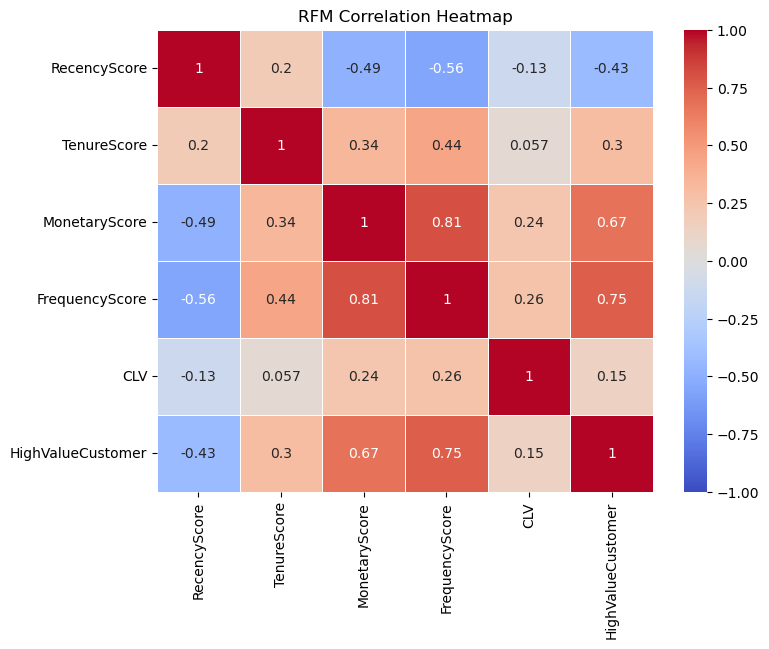

In [15]:
corr= RFM[['RecencyScore', 'TenureScore','MonetaryScore', 'FrequencyScore', 'CLV',  'HighValueCustomer']].corr()

# Generate a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('RFM Correlation Heatmap')
plt.show()


In [16]:
file_path_RFM = os.path.join(current_directory, "../data", "customersRFM.csv")

In [17]:
RFM.to_csv(file_path_RFM, index=False)

In [18]:
import gc
del RFM
gc.collect()
print("Memory cleared!")

Memory cleared!


## Phase 4: Dimensionality Reduction
If needed, apply dimensionality reduction techniques such as Principal Component Analysis (PCA) to reduce the complexity of the data while retaining important information. This step can help improve the efficiency and effectiveness of the clustering algorithms.

In [20]:
RFM = pd.read_csv(file_path_RFM)
RFM.head()

,CustomerID,Recency,RecencyScore,Tenure,TenureScore,Monetary,MonetaryScore,Frequency,FrequencyScore,CLV,RFMScore,SpendFrequencyRatio,HighValueCustomer
0,12347.0,1,0.693147,366,5.905362,4310.00,8.368925,7,2.079442,30170.00,30170.00,3.500000,True
1,12348.0,74,4.317488,357,5.880533,1797.24,7.494564,4,1.609438,7188.96,531983.04,0.053333,False
2,12349.0,18,2.944439,18,2.944439,1757.55,7.472245,1,0.693147,1757.55,31635.90,0.052632,False
3,12350.0,309,5.736572,309,5.736572,334.40,5.815324,1,0.693147,334.40,103329.60,0.003226,False
4,12352.0,35,3.583519,296,5.693732,1545.41,7.343691,11,2.484907,16999.51,594982.85,0.305556,False


In [ ]:
from sklearn.decomposition import PCA

# Assume data is already standardized
df_pca = RFM[['RecencyScore', 'TenureScore','MonetaryScore', 'FrequencyScore', 'HighValueCustomer']]

# Apply PCA
pca = PCA()
pca.fit(df_pca)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Plot eigenvalues
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

# Plot Loadings 
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=df_pca.columns) 
plt.figure(figsize=(10, 5)) 
sns.heatmap(loadings, annot=True, cmap='viridis', cbar=True) 
plt.title('PCA Loadings') 
plt.xlabel('Principal Components') 
plt.ylabel('Original Features') 
plt.show()

In [ ]:
from sklearn.decomposition import FactorAnalysis
# Assume data is already standardized
df_scaled = RFM[['RecencyScore', 'TenureScore','MonetaryScore', 'FrequencyScore', 'HighValueCustomer']]

# Apply Factor Analysis
fa = FactorAnalysis(n_components=3)  # Adjust the number of components based on your need
fa.fit(df_scaled)

# Loadings matrix
loadings = pd.DataFrame(fa.components_.T, columns=[f'Factor{i+1}' for i in range(fa.components_.shape[0])], 
                        index=df_scaled.columns)

# Plot Loadings
plt.figure(figsize=(8, 4))
sns.heatmap(loadings, annot=True, cmap='viridis', cbar=True)
plt.title('Factor Loadings')
plt.xlabel('Factors')
plt.ylabel('Original Features')
plt.show()

# Explained variance
explained_variance = np.var(fa.transform(df_scaled), axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

# Plot explained variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Explained Variance by Factors')
plt.xlabel('Factor')
plt.ylabel('Proportion of Variance Explained')
plt.show()

print(loadings)

In [ ]:
from sklearn.cluster import KMeans

df_mk = RFM[['RecencyScore', 'TenureScore','MonetaryScore', 'FrequencyScore', 'HighValueCustomer']].copy()

# Determine the optimal number of clusters using the Elbow method
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(df_mk)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Apply K-means with the optimal number of clusters (for example, k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
RFM['Cluster'] = kmeans.fit_predict(df_mk)

print(df_mk.head())
# Visualize the clusters
plt.figure(figsize=(10, 5))
sns.scatterplot(data=RFM, x='RecencyScore', y='MonetaryScore', hue='Cluster', palette='viridis')
plt.title('K-means Clustering')
plt.show()

# Show the cluster centroids
#centroids = pd.DataFrame(kmeans.cluster_centers_, columns=RFM.columns)
# Ensure the centroids have the correct columns 
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['RecencyScore', 'TenureScore', 'MonetaryScore', 'FrequencyScore', 'HighValueCustomer'])
print("Cluster Centroids:\n", centroids)


In [ ]:
# Create a scatter plot of the data points with clusters
plt.figure(figsize=(10, 5))
sns.scatterplot(data=RFM, x='RecencyScore', y='MonetaryScore', hue='Cluster', palette='viridis', alpha=0.6, s=50)

# Plot the centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['RecencyScore', 'TenureScore', 'MonetaryScore', 'FrequencyScore', 'HighValueCustomer'])
plt.scatter(centroids['RecencyScore'], centroids['MonetaryScore'], s=100, c='red', label='Centroids', marker='X')

# Add titles and labels
plt.title('K-means Clustering with Centroids')
plt.xlabel('RecencyScore')
plt.ylabel('MonetaryScore')
plt.legend()
plt.show()


## Phase 5: Application of Unsupervised Learning Techniques
Use clustering algorithms like K-means, Hierarchical Clustering, or DBSCAN to segment the customers. These techniques will group customers based on their purchasing behaviors and the features engineered in Phase 3.

In [25]:
import gc
del RFM
gc.collect()
print("Memory cleared!")

Memory cleared!


## 5.1. K-means and FA for "RFM" with ML

In [21]:
from sklearn.decomposition import FactorAnalysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

C:\Users\darya\AppData\Local\Temp\ipykernel_29348\1802810869.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scaled['Cluster'] = kmeans.labels_


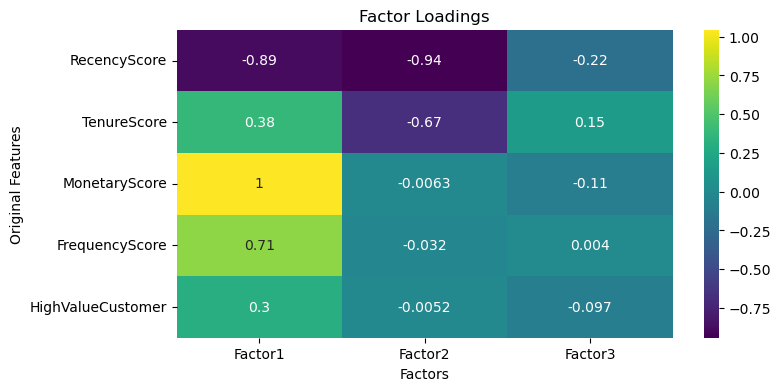

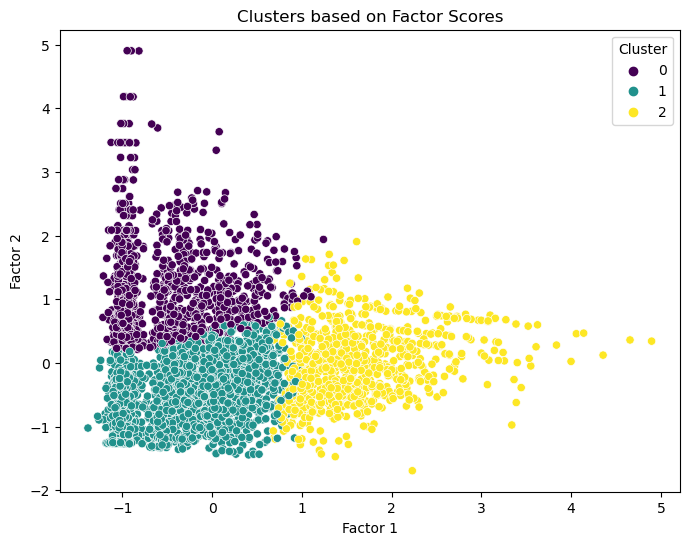

Silhouette Score: 0.420
Davies-Bouldin Index: 0.929
Calinski-Harabasz Index: 2918.968


In [27]:
RFM = pd.read_csv(file_path_RFM)
RFM.head()

# Assume data is already standardized
df_scaled = RFM[['RecencyScore', 'TenureScore', 'MonetaryScore', 'FrequencyScore', 'HighValueCustomer']] #

# Apply Factor Analysis
fa = FactorAnalysis(n_components=3)  # Adjust the number of components based on your need
fa.fit(df_scaled)

# Factor scores
factor_scores = fa.transform(df_scaled)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust the number of clusters based on your need
kmeans.fit(factor_scores)
df_scaled['Cluster'] = kmeans.labels_

# Loadings matrix
loadings = pd.DataFrame(fa.components_.T, columns=[f'Factor{i+1}' for i in range(fa.components_.shape[0])], 
                        index=df_scaled.columns[:-1])

# Plot Loadings
plt.figure(figsize=(8, 4))
sns.heatmap(loadings, annot=True, cmap='viridis', cbar=True)
plt.title('Factor Loadings')
plt.xlabel('Factors')
plt.ylabel('Original Features')
plt.show()

# Explained variance
explained_variance = np.var(factor_scores, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

# Plot explained variance
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
# plt.title('Explained Variance by Factors')
# plt.xlabel('Factor')
# plt.ylabel('Proportion of Variance Explained')
# plt.show()

# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=factor_scores[:, 0], y=factor_scores[:, 1], hue=df_scaled['Cluster'], palette='viridis')
plt.title('Clusters based on Factor Scores')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.legend(title='Cluster')
plt.show()

#print(loadings)
RFM['Cluster'] = df_scaled['Cluster']
RFM.head()

# Calculate the Silhouette Score
silhouette_avg = silhouette_score(factor_scores, df_scaled['Cluster'])
print(f'Silhouette Score: {silhouette_avg:.3f}')

# Calculate the Davies-Bouldin Index
db_index = davies_bouldin_score(factor_scores, df_scaled['Cluster'])
print(f'Davies-Bouldin Index: {db_index:.3f}')

# Calculate the Calinski-Harabasz Index
ch_score = calinski_harabasz_score(factor_scores, df_scaled['Cluster'])
print(f'Calinski-Harabasz Index: {ch_score:.3f}')

In [34]:
import gc
del RFM
gc.collect()
print("Memory cleared!")

Memory cleared!


## 5.2. K-means and FA for "RFM" with ML

C:\Users\darya\AppData\Local\Temp\ipykernel_29348\3535716544.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_scaled['Cluster'] = kmeans.labels_
C:\Users\darya\AppData\Local\Temp\ipykernel_29348\3535716544.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_scaled['Cluster'] = kmeans.predict(test_factor_scores)


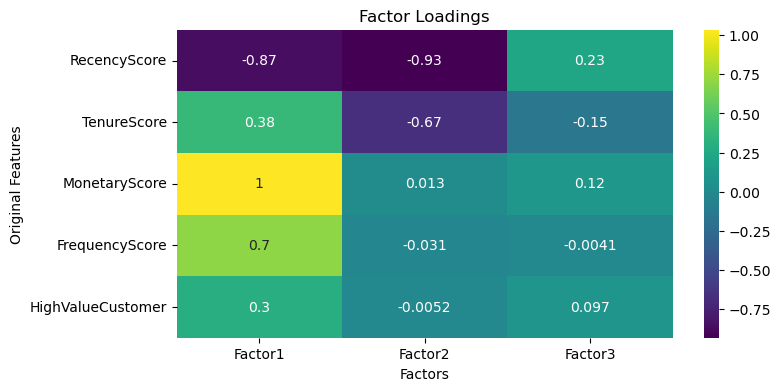

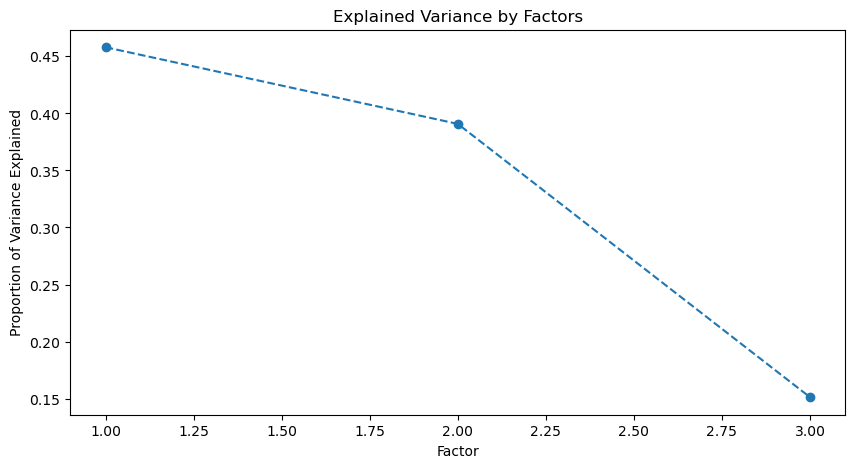

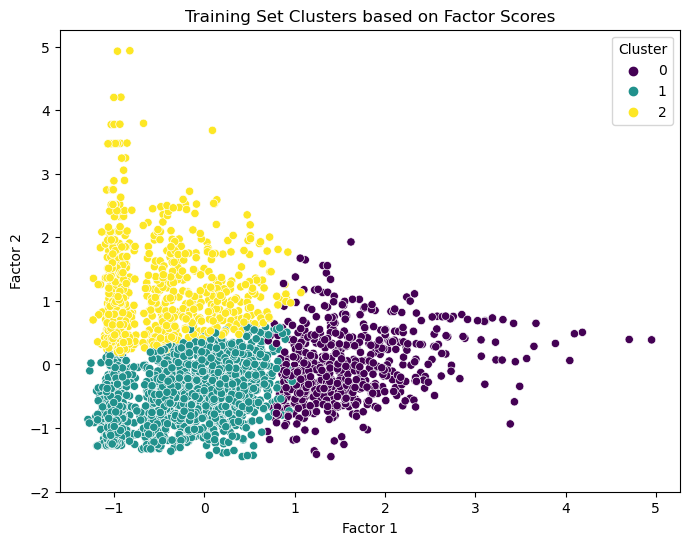

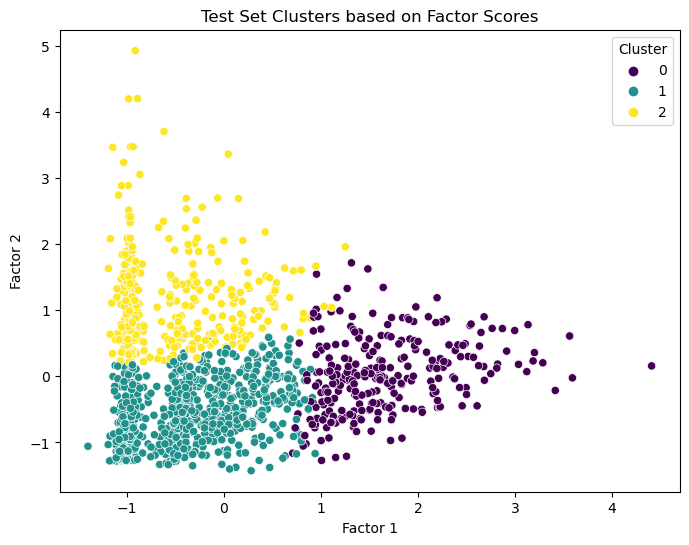

                    Factor1   Factor2   Factor3
RecencyScore      -0.868839 -0.932998  0.228366
TenureScore        0.382439 -0.668132 -0.150760
MonetaryScore      1.035089  0.013228  0.120086
FrequencyScore     0.704132 -0.031138 -0.004144
HighValueCustomer  0.299939 -0.005208  0.096515
Training Silhouette Score: 0.415
Test Silhouette Score: 0.418
Training Davies-Bouldin Index: 0.943
Test Davies-Bouldin Index: 0.922
Training Calinski-Harabasz Index: 1995.994
Test Calinski-Harabasz Index: 906.656


In [35]:
from sklearn.model_selection import train_test_split

RFM = pd.read_csv(file_path_RFM)
RFM.head()

# Split data into training and testing sets
train_df, test_df = train_test_split(RFM, test_size=0.3, random_state=42)

# Assume data is already standardized
train_scaled = train_df[['RecencyScore', 'TenureScore', 'MonetaryScore', 'FrequencyScore', 'HighValueCustomer']]
test_scaled = test_df[['RecencyScore', 'TenureScore', 'MonetaryScore', 'FrequencyScore', 'HighValueCustomer']]

# Apply Factor Analysis on training set
fa = FactorAnalysis(n_components=3)
fa.fit(train_scaled)

# Factor scores
train_factor_scores = fa.transform(train_scaled)
test_factor_scores = fa.transform(test_scaled)

# K-means clustering on training set
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(train_factor_scores)
train_scaled['Cluster'] = kmeans.labels_

# Predict clusters for test set
test_scaled['Cluster'] = kmeans.predict(test_factor_scores)

# Loadings matrix
loadings = pd.DataFrame(fa.components_.T, columns=[f'Factor{i+1}' for i in range(fa.components_.shape[0])], 
                        index=train_scaled.columns[:-1])

# Plot Loadings
plt.figure(figsize=(8, 4))
sns.heatmap(loadings, annot=True, cmap='viridis', cbar=True)
plt.title('Factor Loadings')
plt.xlabel('Factors')
plt.ylabel('Original Features')
plt.show()

# Explained variance
explained_variance = np.var(train_factor_scores, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

# Plot explained variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Explained Variance by Factors')
plt.xlabel('Factor')
plt.ylabel('Proportion of Variance Explained')
plt.show()

# Plot clusters for training set
plt.figure(figsize=(8, 6))
sns.scatterplot(x=train_factor_scores[:, 0], y=train_factor_scores[:, 1], hue=train_scaled['Cluster'], palette='viridis')
plt.title('Training Set Clusters based on Factor Scores')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.legend(title='Cluster')
plt.show()

# Plot clusters for test set
plt.figure(figsize=(8, 6))
sns.scatterplot(x=test_factor_scores[:, 0], y=test_factor_scores[:, 1], hue=test_scaled['Cluster'], palette='viridis')
plt.title('Test Set Clusters based on Factor Scores')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.legend(title='Cluster')
plt.show()

# Print loadings
print(loadings)

# Calculate the Silhouette Score
silhouette_avg_train = silhouette_score(train_factor_scores, train_scaled['Cluster'])
silhouette_avg_test = silhouette_score(test_factor_scores, test_scaled['Cluster'])
print(f'Training Silhouette Score: {silhouette_avg_train:.3f}')
print(f'Test Silhouette Score: {silhouette_avg_test:.3f}')

# Calculate the Davies-Bouldin Index
db_index_train = davies_bouldin_score(train_factor_scores, train_scaled['Cluster'])
db_index_test = davies_bouldin_score(test_factor_scores, test_scaled['Cluster'])
print(f'Training Davies-Bouldin Index: {db_index_train:.3f}')
print(f'Test Davies-Bouldin Index: {db_index_test:.3f}')

# Calculate the Calinski-Harabasz Index
ch_score_train = calinski_harabasz_score(train_factor_scores, train_scaled['Cluster'])
ch_score_test = calinski_harabasz_score(test_factor_scores, test_scaled['Cluster'])
print(f'Training Calinski-Harabasz Index: {ch_score_train:.3f}')
print(f'Test Calinski-Harabasz Index: {ch_score_test:.3f}')


In [36]:
# Ensure 'CustomerID' is a common column to merge on
train_scaled.loc[:, 'CustomerID'] = train_df['CustomerID']
test_scaled.loc[:, 'CustomerID'] = test_df['CustomerID']

# Concatenate training and testing dataframes with cluster labels
combined_scaled = pd.concat([train_scaled, test_scaled])

# Merge clusters back to original RFM DataFrame
RFM = RFM.merge(combined_scaled[['CustomerID', 'Cluster']], on='CustomerID', how='left')

# Display the updated RFM DataFrame
RFM.head()


C:\Users\darya\AppData\Local\Temp\ipykernel_29348\830915703.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_scaled.loc[:, 'CustomerID'] = train_df['CustomerID']
C:\Users\darya\AppData\Local\Temp\ipykernel_29348\830915703.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_scaled.loc[:, 'CustomerID'] = test_df['CustomerID']


,CustomerID,Recency,RecencyScore,Tenure,TenureScore,Monetary,MonetaryScore,Frequency,FrequencyScore,CLV,RFMScore,SpendFrequencyRatio,HighValueCustomer,Cluster
0,12347.0,1,0.693147,366,5.905362,4310.00,8.368925,7,2.079442,30170.00,30170.00,3.500000,True,0
1,12348.0,74,4.317488,357,5.880533,1797.24,7.494564,4,1.609438,7188.96,531983.04,0.053333,False,1
2,12349.0,18,2.944439,18,2.944439,1757.55,7.472245,1,0.693147,1757.55,31635.90,0.052632,False,2
3,12350.0,309,5.736572,309,5.736572,334.40,5.815324,1,0.693147,334.40,103329.60,0.003226,False,1
4,12352.0,35,3.583519,296,5.693732,1545.41,7.343691,11,2.484907,16999.51,594982.85,0.305556,False,0


In [39]:
file_path_Profile = os.path.join(current_directory, "../data", "customersProfile.csv")
RFM.to_csv(file_path_Profile, index=False)

## Phase 6: Interpretation of Segments and Marketing Actions

| Cluster  | Key Traits                             | Marketing Actions                                |
|----------|----------------------------------------|--------------------------------------------------|
| Cluster 0| Loyal, frequent, high-spending customers| 1. VIP/Loyalty Programs                           |
|          |                                        | 2. Personalized Offers                            |
|          |                                        | 3. Engagement & Retention                         |
| Cluster 1| Moderate engagement and spending customers| 1. Re-engagement Campaigns                       |
|          |                                        | 2. Time-Limited Discounts                         |
|          |                                        | 3. Cross-Selling                                  |
| Cluster 2| Infrequent and low-spending customers  | 1. Win-Back Campaigns                             |
|          |                                        | 2. Referral Programs                              |
|          |                                        | 3. Sampling/Trial Offers                          |


## Phase 7: Model Export
Once the segmentation model is finalized, export it for deployment. This includes saving the model and any necessary preprocessing steps so it can be applied to new data in the future.

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis
from sklearn.cluster import KMeans
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

# Load and display the dataset
RFM = pd.read_csv(file_path_RFM)
col = ['RecencyScore', 'TenureScore', 'MonetaryScore', 'FrequencyScore', 'HighValueCustomer']

# Split data into training and testing sets
train_df, test_df = train_test_split(RFM, test_size=0.3, random_state=42)

train_scaled = train_df[col]
test_scaled = test_df[col]

# Custom transformer for Factor Analysis
class FactorAnalysisTransformer(TransformerMixin):
    def __init__(self, n_components):
        self.n_components = n_components
        self.fa = FactorAnalysis(n_components=n_components)

    def fit(self, X, y=None):
        self.fa.fit(X)
        return self

    def transform(self, X, y=None):
        return self.fa.transform(X)

# Create a pipeline without scaling
pipeline = Pipeline([
    ('factor_analysis', FactorAnalysisTransformer(n_components=3)),
    ('kmeans', KMeans(n_clusters=3, random_state=42))
])

# Fit the pipeline on the training data and predict on the test data
pipeline.fit(train_scaled)
train_df['Cluster'] = pipeline.predict(train_scaled)
test_df['Cluster'] = pipeline.predict(test_scaled)

# Function to preprocess and predict the cluster for new client data
def preprocess_and_predict(new_client_data):
    return pipeline.predict(new_client_data)


# Example new client data
new_client_data = pd.DataFrame({'RecencyScore': [1, 2], 'TenureScore': [5, 2], 'MonetaryScore': [2, 12], 'FrequencyScore': [1, 3], 'HighValueCustomer': [1, 0]})
new_client_df = new_client_data.copy()

# Preprocess and predict the cluster for the new client
new_client_df['Cluster'] = preprocess_and_predict(new_client_data[col])

# Display the new client data with cluster label
new_client_df.head()



,RecencyScore,TenureScore,MonetaryScore,FrequencyScore,HighValueCustomer,Cluster
0,1,5,2,1,1,2
1,2,2,12,3,0,0


### Training and Saving the Pipeline

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis
from sklearn.cluster import KMeans
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import pickle

# Load and display the dataset
RFM = pd.read_csv(file_path_RFM)
col = ['RecencyScore', 'TenureScore', 'MonetaryScore', 'FrequencyScore', 'HighValueCustomer']

# Split data into training and testing sets
train_df, test_df = train_test_split(RFM, test_size=0.3, random_state=42)

train_scaled = train_df[col]
test_scaled = test_df[col]

# Custom transformer for Factor Analysis
class FactorAnalysisTransformer(TransformerMixin):
    def __init__(self, n_components):
        self.n_components = n_components
        self.fa = FactorAnalysis(n_components=n_components)

    def fit(self, X, y=None):
        self.fa.fit(X)
        return self

    def transform(self, X, y=None):
        return self.fa.transform(X)

# Create a pipeline without scaling
pipeline = Pipeline([
    ('factor_analysis', FactorAnalysisTransformer(n_components=3)),
    ('kmeans', KMeans(n_clusters=3, random_state=42))
])

# Fit the pipeline on the training data and predict on the test data
pipeline.fit(train_scaled)
train_df['Cluster'] = pipeline.predict(train_scaled)
test_df['Cluster'] = pipeline.predict(test_scaled)

# Save the pipeline to a file
with open('pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

### Loading the Pipeline and Making Predictions

In [50]:
import pandas as pd
import pickle

# Load the pipeline from the file
with open('pipeline.pkl', 'rb') as file:
    loaded_pipeline = pickle.load(file)

# Function to preprocess and predict the cluster for new client data
def preprocess_and_predict(new_client_data):
    return loaded_pipeline.predict(new_client_data)

# Example new client data
new_client_data = pd.DataFrame({'RecencyScore': [1, 2], 'TenureScore': [5, 2], 'MonetaryScore': [2, 12], 'FrequencyScore': [1, 3], 'HighValueCustomer': [1, 0]})
new_client_df = new_client_data.copy()

# Preprocess and predict the cluster for the new client
new_client_df['Cluster'] = preprocess_and_predict(new_client_data[col])

# Display the new client data with cluster label
new_client_df.head()

,RecencyScore,TenureScore,MonetaryScore,FrequencyScore,HighValueCustomer,Cluster
0,1,5,2,1,1,2
1,2,2,12,3,0,0
